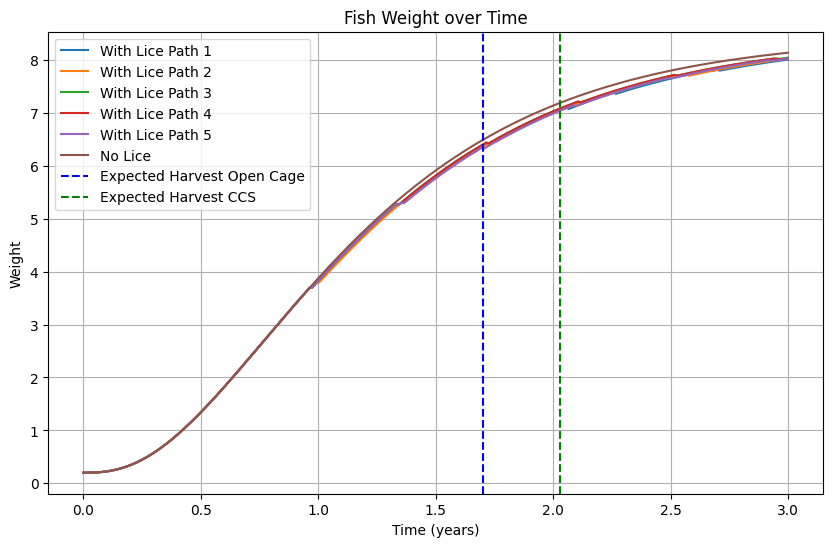

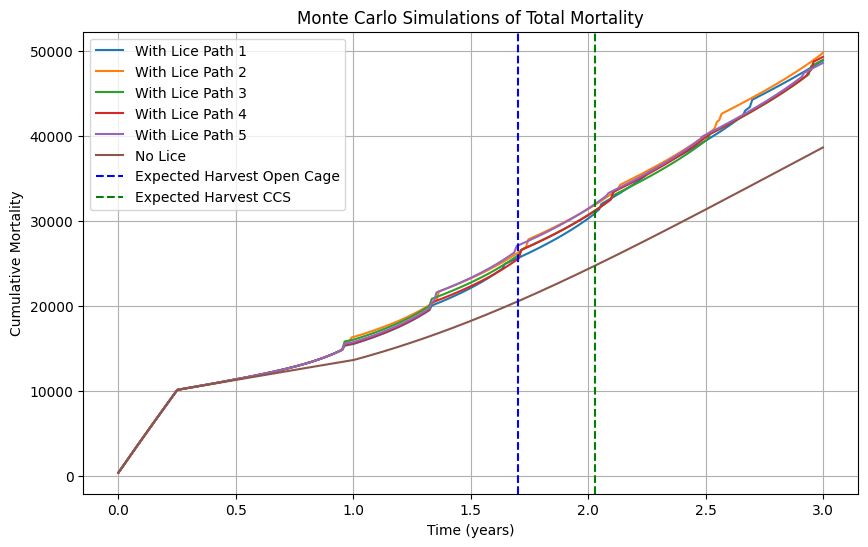

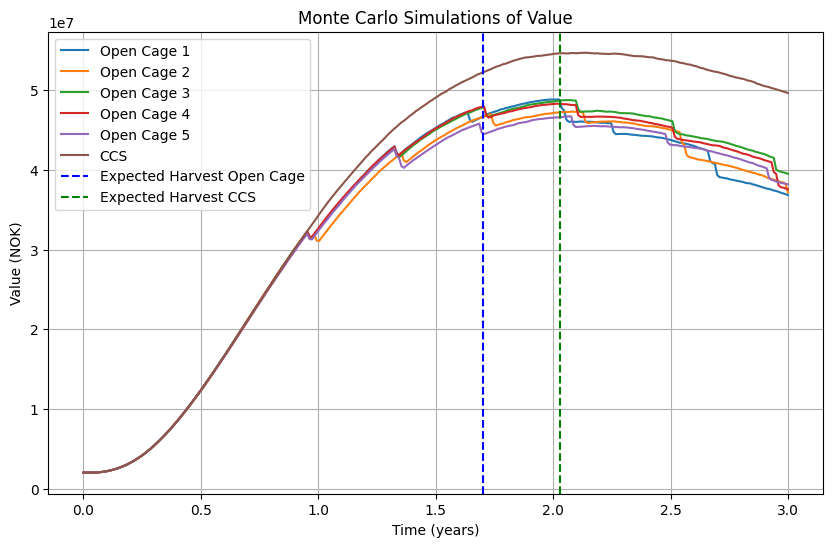

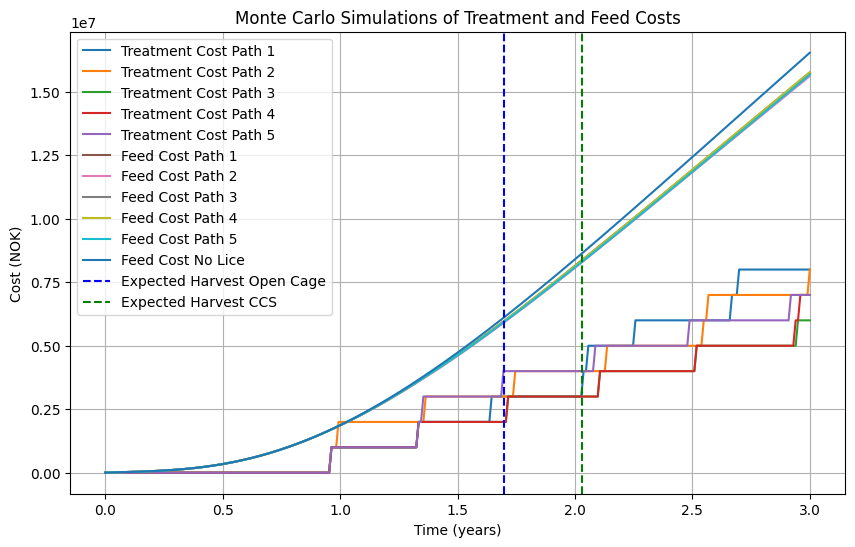

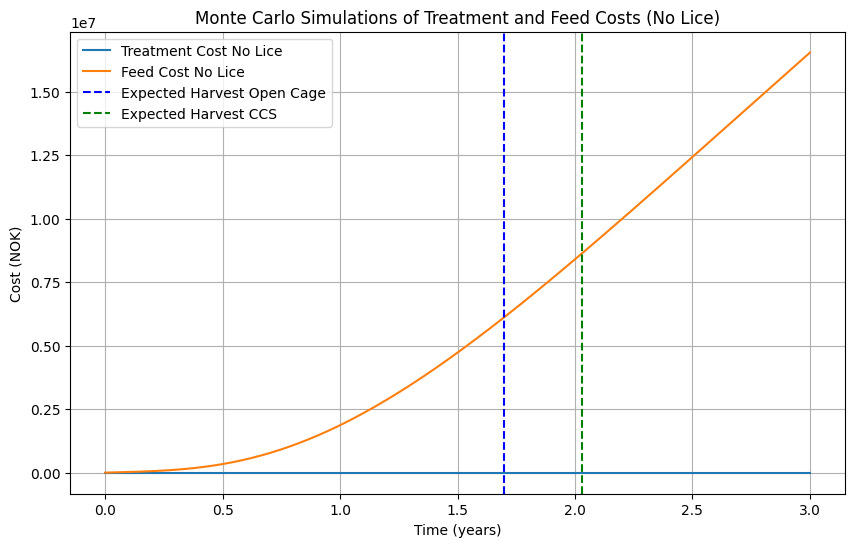

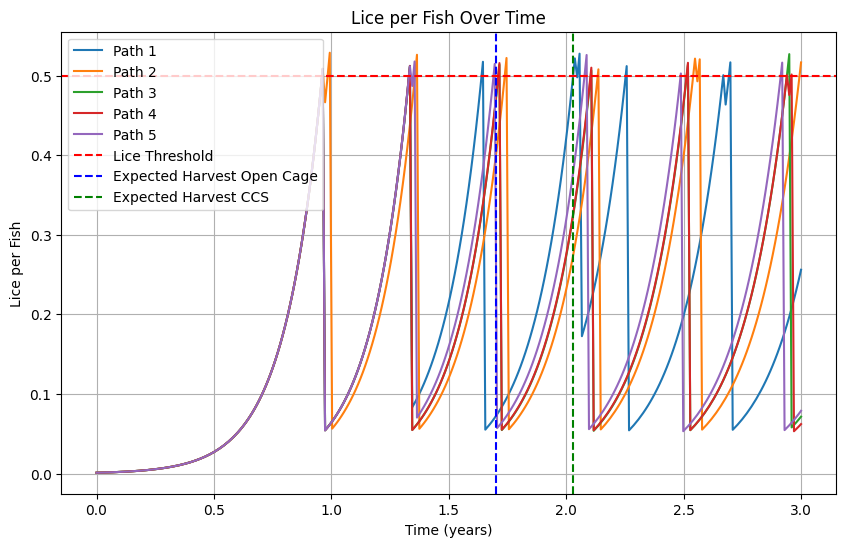

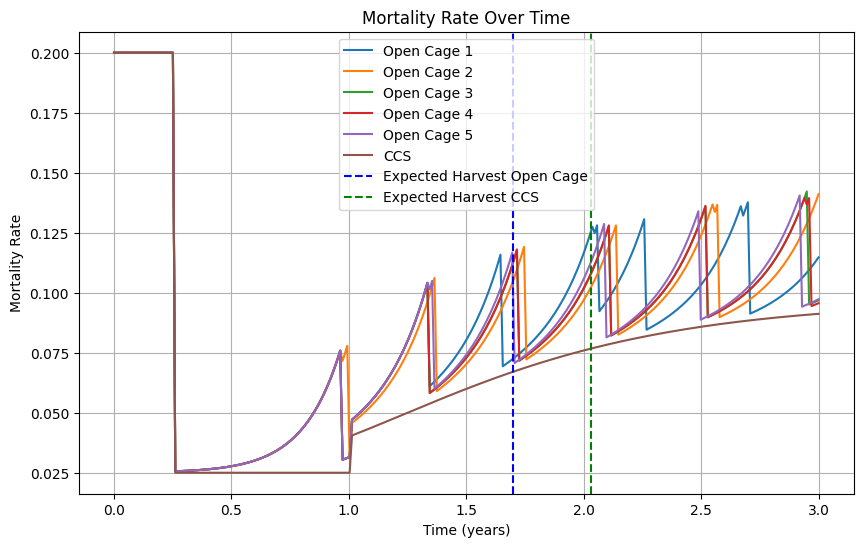

In [214]:
import numpy as np
import matplotlib.pyplot as plt

# Von Bertalanffy growth model parameters
w_inf = 6       # Maximum possible biomass in kg
a = 1.113       # Growth constant (scales growth)
b = 1.097       # Shape parameter
c = 1.43        # Growth rate constant

# Initial conditions and costs
initial_biomass = 0.2            # Initial weight of fish in kg
initial_fish = 200000            # Initial number of fish in knot
harvesting_cost_per_kg = 4       # Cost of harvest per kg in NOK
feed_cost_per_kg_year = 5        # Cost of feed per kg per year in NOK
lice_treatment_cost = 1000000    # Cost of lice treatment
FCR_CCS = 1.25
FCR = 1.25
# Host-parasite parameters     
mu = 0.025                       # Intrinsic mortality of salmon (OpenKnot)
alpha = 0.1                      # Mortality from lice per salmon
mu_smoltification_inc = 0.2
mu_smoltification_inc_css = 0.2
weight_mort_inc = 0.001
weight_mort_inc_css = 0.001
lambda_growth = 7.0143           # Lice growth rate
lice_threshold = 0.5             # Lice per fish threshold for removal
beta1 = 0.0829                   # Beta distribution parameter for removal success
beta2 = 0.0281                   # Beta distribution parameter for removal success
reduced_growth_treatment = 0.01  # How lice treatments will impact growth rate

# Mean-reversion parameters for spot price
mean_reversion_speed = 0.001
long_term_mean = 50
price_volatility = 0.2
initial_price = 50

# Simulation parameters
time_horizon = 3                 # in years
dt = 0.01                        # Time step
T = int(time_horizon / dt)       # Number of time steps
num_simulations = 1000          # Number of Monte Carlo paths
time = np.linspace(0, time_horizon, T)
r = 0.0303                       # Discount rate

# von Bertalanffy growth function for biomass B(t)
def biomass(t, w_inf, a, b, c, lice_per_fish_value):
    if lice_per_fish_value > 0:
        return w_inf * (a - b * np.exp(-c * t)) ** 3 + initial_biomass
    else:
        return w_inf * (a - b * np.exp(-c * t)) ** 3 + initial_biomass

# Simulate mean-reverting spot price (Ornstein-Uhlenbeck process)
def mean_reverting_price(P0, dt, T, mean_reversion_speed, long_term_mean, price_volatility):
    prices = np.zeros(T)
    prices[0] = P0
    for t in range(1, T):
        dP = mean_reversion_speed * (long_term_mean - prices[t-1]) * dt \
             + price_volatility * np.sqrt(dt) * np.random.randn()
        prices[t] = prices[t-1] + dP
    return prices

# Function to calculate dynamic mortality rate based on weight and lice count
def calculate_mortality_rate_dynamic(B_t, N_t, lice_per_fish_value, t, dt):
    if t * dt <= 3/12:  # First three months
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu_smoltification_inc
        else:
            mortality_rate_dynamic = mu_smoltification_inc_css
    elif t * dt <= 1:
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu
    else: 
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + (weight_mort_inc * B_t ** 2) + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu + (weight_mort_inc_css * B_t ** 2)
    return mortality_rate_dynamic

# Function to simulate fish population with cumulative mortality and calculate average dead weight
def simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, initial_lice_per_fish, FCR, c):
    # Initialize arrays to store simulation results
    all_values = np.zeros((num_simulations, T))
    harvesting_costs = np.zeros((num_simulations, T))
    feed_costs = np.zeros((num_simulations, T))
    treatment_costs = np.zeros((num_simulations, T))
    lice_per_fish = np.zeros((num_simulations, T))
    mortality_rate = np.zeros((num_simulations, T))
    total_mortality = np.zeros((num_simulations, T))
    average_dead_weight = np.zeros(num_simulations)  # To store average dead weight for each simulation
    B_t_array = np.zeros((num_simulations, T))  # Biomass at each time step
    D_t_array = np.zeros((num_simulations, T))  # Deaths at each time step

    for i in range(num_simulations):
        c_simulation = c
        N_t = initial_fish
        P_t = initial_lice_per_fish * N_t  # Initial lice population
        prices = mean_reverting_price(initial_price, dt, T, mean_reversion_speed, long_term_mean, price_volatility)
        cumulative_feed_cost = 0
        cumulative_treatment_cost = 0
        cumulative_death = 0

        for t in range(T):
            lice_per_fish_value = P_t / N_t
            lice_per_fish[i, t] = lice_per_fish_value
            B_t = biomass(t * dt, w_inf, a, b, c_simulation, lice_per_fish_value)
            B_t_array[i, t] = B_t  # Store B_t

            # Calculate dynamic mortality rate
            mortality_rate_dynamic = calculate_mortality_rate_dynamic(B_t, N_t, lice_per_fish_value, t, dt)
            mortality_rate[i, t] = mortality_rate_dynamic

            feed_cost_t = B_t * N_t * feed_cost_per_kg_year * dt * FCR

            # Update number of fish based on cumulative mortality
            D_t = N_t * mortality_rate_dynamic * dt
            D_t_array[i, t] = D_t  # Store D_t
            cumulative_death += D_t
            N_t -= D_t
            N_t = max(N_t, 0)  # Ensure N_t doesn't go below zero

            # Update lice population
            if N_t > 0:
                P_t += (lambda_growth * (N_t / initial_fish) - (mu + alpha * lice_per_fish_value)) * P_t * dt
            else:
                P_t = 0  # No fish left, so lice population is zero

            # Lice removal if the threshold is exceeded
            if lice_per_fish_value >= lice_threshold and N_t > 0:
                removal_success = 0.1 + 0.8 * np.random.beta(beta1, beta2)
                P_t *= (1 - removal_success)
                # Small mortality from treatment
                mortality_from_treatment = N_t * (1 - np.random.uniform(0.995, 1.0))
                N_t -= mortality_from_treatment
                N_t = max(N_t, 0)
                cumulative_treatment_cost += lice_treatment_cost
                c_simulation *= (1 - reduced_growth_treatment)
                # Add treatment deaths to D_t_array
                D_t_array[i, t] += mortality_from_treatment
                # Update cumulative_death with treatment deaths
                cumulative_death += mortality_from_treatment

            # Calculate feed cost and cumulative feed cost
            cumulative_feed_cost += feed_cost_t
            feed_costs[i, t] = cumulative_feed_cost

            # Calculate cumulative treatment cost
            treatment_costs[i, t] = cumulative_treatment_cost
            total_mortality[i, t] = cumulative_death

            # Value at time t (Biomass * Number of Fish * Spot Price) minus costs
            all_values[i, t] = B_t * N_t * prices[t] - feed_costs[i, t] - treatment_costs[i, t]
            harvesting_costs[i, t] = B_t * N_t * harvesting_cost_per_kg

        # Calculate average dead weight for this simulation
        total_D_t = np.sum(D_t_array)
        if total_D_t > 0:
            average_dead_weight[i] = np.sum(D_t_array * B_t_array) / total_D_t
        else:
            average_dead_weight[i] = 0  # No deaths occurred

    return (all_values, harvesting_costs, feed_costs, lice_per_fish, treatment_costs,
            mortality_rate, total_mortality, B_t_array, D_t_array)


# Run Monte Carlo simulation without lice
results_no_lice = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, c)
(simulated_values_no_lice, harvesting_costs_no_lice, feed_costs_no_lice, lice_per_fish_no_lice,
 treatment_costs_no_lice, mortality_rate_no_lice, cumulative_death_no_lice, B_t_no_Lice, D_t_no_Lice) = results_no_lice

# Run Monte Carlo simulation with initial lice infestation
results_lice = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, c)
(simulated_values, harvesting_costs, feed_costs, lice_per_fish, treatment_costs,
 mortality_rate, cumulative_death, B_t, D_t) = results_lice

# # Calculate average dead weight across all simulations
# mean_average_dead_weight = np.mean(average_dead_weight)
# mean_average_dead_weight_no_lice = np.mean(average_dead_weight_no_lice)

# print(f"Average weight at death with lice: {mean_average_dead_weight:.2f} kg")
# print(f"Average weight at death without lice: {mean_average_dead_weight_no_lice:.2f} kg")

# Plotting simulated values
# Updated code with distinct colors for each line and applied consistently across all plots

# Defining harvest line information
harvest_lines = [
    (1.7, "Expected Harvest Open Cage", 'blue'), 
    (2.03, "Expected Harvest CCS", 'green')
]

# Updated plotting with consistent lines for all provided plots

# Plotting simulated values (Fish Weight over Time)
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random B(t) paths with lice infestations
    plt.plot(time, B_t[i, :], label=f"With Lice Path {i+1}")
for i in range(1):  # Plot 1 random path without lice
    plt.plot(time, B_t_no_Lice[i, :], label="No Lice")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Fish Weight over Time")
plt.xlabel("Time (years)")
plt.ylabel("Weight")
plt.grid(True)
plt.legend()
plt.show()

# Plotting cumulative mortality
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random paths with lice infestations
    plt.plot(time, cumulative_death[i, :], label=f"With Lice Path {i+1}")
for i in range(1):  # Plot 1 random path without lice
    plt.plot(time, cumulative_death_no_lice[i, :], label="No Lice")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Monte Carlo Simulations of Total Mortality")
plt.xlabel("Time (years)")
plt.ylabel("Cumulative Mortality")
plt.grid(True)
plt.legend()
plt.show()

# Plotting simulated values (Value)
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random paths with lice infestations
    plt.plot(time, simulated_values[i, :], label=f"Open Cage {i+1}")
for i in range(1):  # Plot 1 random path without lice
    plt.plot(time, simulated_values_no_lice[i, :], label="CCS")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Monte Carlo Simulations of Value")
plt.xlabel("Time (years)")
plt.ylabel("Value (NOK)")
plt.grid(True)
plt.legend()
plt.show()

# Plotting treatment and feed costs
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random paths of treatment costs
    plt.plot(time, treatment_costs[i, :], label=f"Treatment Cost Path {i+1}")
for i in range(5):  # Plot 5 random paths of feed costs
    plt.plot(time, feed_costs[i, :], label=f"Feed Cost Path {i+1}")
for i in range(1):  # Plot 1 random path of feed costs without lice
    plt.plot(time, feed_costs_no_lice[i, :], label="Feed Cost No Lice")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Monte Carlo Simulations of Treatment and Feed Costs")
plt.xlabel("Time (years)")
plt.ylabel("Cost (NOK)")
plt.grid(True)
plt.legend()
plt.show()

# Plotting treatment costs for no lice
plt.figure(figsize=(10, 6))
for i in range(1):  # Plot 1 random path of treatment costs without lice
    plt.plot(time, treatment_costs_no_lice[i, :], label="Treatment Cost No Lice")
for i in range(1):  # Plot 1 random path of feed costs without lice
    plt.plot(time, feed_costs_no_lice[i, :], label="Feed Cost No Lice")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Monte Carlo Simulations of Treatment and Feed Costs (No Lice)")
plt.xlabel("Time (years)")
plt.ylabel("Cost (NOK)")
plt.grid(True)
plt.legend()
plt.show()

# Plotting lice per fish dynamics
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random paths of lice per fish
    plt.plot(time, lice_per_fish[i, :], label=f"Path {i+1}")
plt.axhline(lice_threshold, color='r', linestyle='--', label="Lice Threshold")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Lice per Fish Over Time")
plt.xlabel("Time (years)")
plt.ylabel("Lice per Fish")
plt.grid(True)
plt.legend()
plt.show()

# Plotting mortality rate dynamics
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random paths with lice
    plt.plot(time, mortality_rate[i, :], label=f"Open Cage {i+1}")
for i in range(1):  # Plot 1 random path without lice
    plt.plot(time, mortality_rate_no_lice[i, :], label="CCS")
for line, label, color in harvest_lines:
    plt.axvline(x=line, color=color, linestyle='--', label=label)
plt.title("Mortality Rate Over Time")
plt.xlabel("Time (years)")
plt.ylabel("Mortality Rate")
plt.grid(True)
plt.legend()
plt.show()


In [196]:
from sklearn.linear_model import LinearRegression
import numpy as np

def continuation_value(value_salmon, discounted_payoff, degree=3):
    """
    Calculates the continuation value using polynomial regression.
    
    Parameters:
    - stock_prices: Stock prices at the current time step for in-the-money paths.
    - discounted_payoff: Discounted payoff for in-the-money paths.
    - degree: Degree of the polynomial for the regression (default: 2).
    
    Returns:
    - Continuation values for each stock price.
    """
    # Fit a polynomial regression model
    coeffs = np.polyfit(value_salmon, discounted_payoff, deg=degree)
    return np.polyval(coeffs, value_salmon)

def lsmc(paths, K, r, T, n_steps, B_t, D_t, poly_degree=3):
    """
    Implements the Longstaff-Schwartz Least Squares Monte Carlo (LSM) algorithm to price American options.

    Parameters:
        paths (ndarray): Simulated asset price paths (number of paths, number of time steps).
        K (float): Cost of Harvest C(H)
        r (float): Risk-free interest rate (annual).
        T (float): Maximum growth time (time to maturity)
        n_steps (int): Number of discrete time steps.
        poly_degree (int): Degree of polynomial used in regression for continuation values (default: 2).

    Returns:
        tuple: Estimated value of knot and an array of optimal exercise times.
    """
    dt = T / n_steps
    discount = np.exp(-r * dt)
    
    immediate_exercise_value = np.maximum(paths - K, 0)
    discounted_cash_flow = immediate_exercise_value[:, -1]
    exercise_times = np.full(paths.shape[0], n_steps)
    average_dead_weight = np.zeros(paths.shape[0])  # Fixed-size array for average dead weights
    total_mortality = np.zeros(paths.shape[0])  # Fixed-size array for total mortality


    for t in range(n_steps - 1, 0, -1):
        in_the_money = (paths[:, t] > K[:, t])
        paths_itm = np.where(in_the_money)[0]
        discounted_cash_flow *= discount

        if len(paths_itm) > 0:
            X = paths[paths_itm, t]
            Y = discounted_cash_flow[paths_itm]

            continuation_vals = continuation_value(X, Y, degree=poly_degree)
            exercise = immediate_exercise_value[in_the_money, t] > continuation_vals
            discounted_cash_flow[in_the_money] = np.where(exercise, immediate_exercise_value[in_the_money, t], Y)
            exercise_times[in_the_money] = np.where(exercise, t, exercise_times[in_the_money])
    for i in range(num_simulations):
        total_D_t = np.sum(D_t[i][:exercise_times[i] + 1])
        average_dead_weight[i] = np.sum(D_t[i][:exercise_times[i] + 1] * B_t[i][:exercise_times[i] + 1]) / total_D_t
        total_mortality[i] = total_D_t / initial_fish

    knot_value = np.mean(discounted_cash_flow) * discount
    return knot_value, exercise_times, average_dead_weight, np.mean(total_mortality)

In [206]:
knot_value, exercise_times, average_dead_weight, average_mortality_rate = lsmc(simulated_values, harvesting_costs, r, time_horizon, T, B_t, D_t)
knot_value_no_lice, exercise_times_no_lice, average_dead_weight_no_lice, average_mortality_rate_no_lice = lsmc(simulated_values_no_lice, harvesting_costs, r, time_horizon, T, B_t_no_Lice, D_t_no_Lice)
    
print('One round of salmon farming with lice infestations is worth:', round(knot_value, 2), 'NOK')
print('One round of salmon farming without lice infestations is worth:', round(knot_value_no_lice, 2), 'NOK')
print('Difference: ', knot_value_no_lice - knot_value)
print('Difference (%):', round((knot_value_no_lice / knot_value) - 1, 2) * 100, '%')

#Important to remember that this is only the revenue gain, not the gains in profits from no lice_removal costs
# results = np.zeros(M)

mean_average_dead_weight = np.mean(average_dead_weight)
mean_average_dead_weight_no_lice = np.mean(average_dead_weight_no_lice)

print('Average mortality rate at harvest: ', round(average_mortality_rate * 100, 2), '%')
print('Average mortality rate at harvest with no lice: ', round(average_mortality_rate_no_lice * 100, 2), '%')

print(f"Average weight at death with lice: {mean_average_dead_weight:.2f} kg")
print(f"Average weight at death without lice: {mean_average_dead_weight_no_lice:.2f} kg")

One round of salmon farming with lice infestations is worth: 44047365.07 NOK
One round of salmon farming without lice infestations is worth: 51013171.59 NOK
Difference:  6965806.523181267
Difference (%): 16.0 %
Average mortality rate at harvest:  13.27 %
Average mortality rate at harvest with no lice:  11.69 %
Average weight at death with lice: 3.27 kg
Average weight at death without lice: 3.21 kg


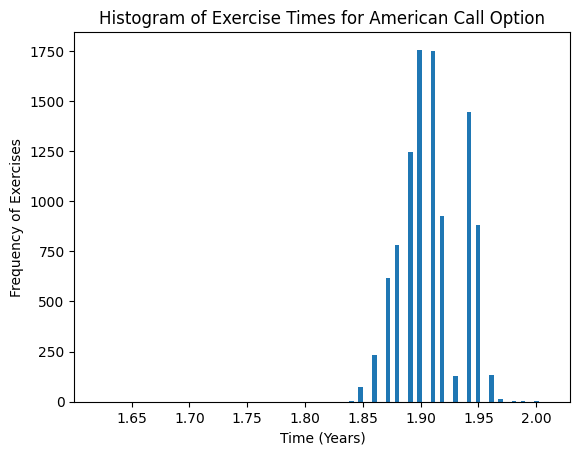

Number of exercise times less than 185: 14
Number of exercise times greater than 185: 49626


In [194]:
M = 5
# Initialize counters
exercise_times_less_than_180 = 0
exercise_times_greater_than_180 = 0
all_exercise_times = np.array([])
lice_treatment_cost = 1000000    # Cost of lice treatment
lice_threshold = 0.2

# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        10000, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, c
    )
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Count instances of exercise times (using raw exercise_times)
    exercise_times_less_than_180 += np.sum(exercise_times < 185)  # Adjust threshold to 185 as required
    exercise_times_greater_than_180 += np.sum(exercise_times > 185)  # Adjust threshold to 185 as required

    # Collect all exercise times for plotting
    all_exercise_times = np.concatenate((all_exercise_times, exercise_times))

# Convert exercise times to years and round to two decimal places
all_exercise_times_in_years = np.round(all_exercise_times / 100, 2)

# Plot the histogram with updated exercise times
plt.hist(all_exercise_times_in_years, bins=T//3, weights=np.ones_like(all_exercise_times_in_years)/M)
plt.title('Histogram of Exercise Times for American Call Option')
plt.xlabel('Time (Years)')
plt.ylabel('Frequency of Exercises')
plt.show()

# Print the results
print(f"Number of exercise times less than 185: {exercise_times_less_than_180}")
print(f"Number of exercise times greater than 185: {exercise_times_greater_than_180}")


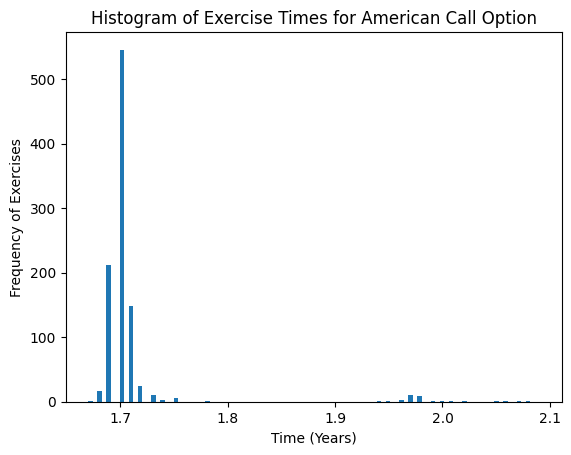

Number of exercise times less than 185: 4844
Number of exercise times greater than 185: 156


In [221]:
M = 5
# Initialize counters
exercise_times_less_than_180 = 0
exercise_times_greater_than_180 = 0
all_exercise_times = np.array([])
lice_threshold = 0.5
lice_treatment_cost = 1000000    # Cost of lice treatment


# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        1000, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, c
    )
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Count instances of exercise times (using raw exercise_times)
    exercise_times_less_than_180 += np.sum(exercise_times < 185)  # Adjust threshold to 185 as required
    exercise_times_greater_than_180 += np.sum(exercise_times > 185)  # Adjust threshold to 185 as required

    # Collect all exercise times for plotting
    all_exercise_times = np.concatenate((all_exercise_times, exercise_times))

# Convert exercise times to years and round to two decimal places
all_exercise_times_in_years = np.round(all_exercise_times / 100, 2)

# Plot the histogram with updated exercise times
plt.hist(all_exercise_times_in_years, bins=T//3, weights=np.ones_like(all_exercise_times_in_years)/M)
plt.title('Histogram of Exercise Times for American Call Option')
plt.xlabel('Time (Years)')
plt.ylabel('Frequency of Exercises')
plt.show()

# Print the results
print(f"Number of exercise times less than 185: {exercise_times_less_than_180}")
print(f"Number of exercise times greater than 185: {exercise_times_greater_than_180}")

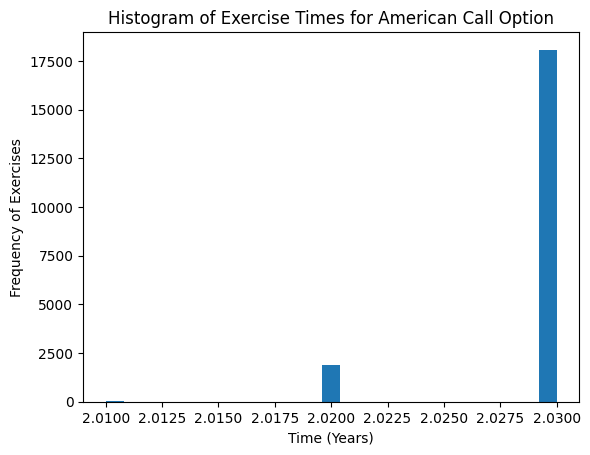

In [ ]:
M = 1

all_exercise_times = np.array([])

# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(10000, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, c)
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight, _ = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)
    # Filter and collect all exercise times that are before the last step (i.e., early exercises)
    all_exercise_times = np.concatenate((all_exercise_times, exercise_times[exercise_times < T]))

# Convert exercise times to years and round to two decimal places
all_exercise_times_in_years = np.round(all_exercise_times / 100, 2)

# Plot the histogram with updated exercise times
plt.hist(all_exercise_times_in_years, bins=T//12, weights=np.ones_like(all_exercise_times_in_years)/M)
plt.title('Histogram of Exercise Times for American Call Option')
plt.xlabel('Time (Years)')
plt.ylabel('Frequency of Exercises')
plt.show()